In [1]:
# vivarium / pandas combination here is giving a ton of future warnings
# try to suppress them...

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# this works if you execute it _before_ importing vivarium

In [2]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [3]:
path = Path('/ihme/homes/abie/projects/2023/'
            'vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/abie/projects/2023/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [4]:
%cd /ihme/homes/abie/projects/2023/vivarium_nih_us_cvd
!git status

/mnt/share/homes/abie/projects/2023/vivarium_nih_us_cvd
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/vivarium_nih_us_cvd/constants/data_values.py
	modified:   src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd_no_treatment.yaml
	src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd_no_treatment.yaml~

no changes added to commit (use "git add" and/or "git commit -a")


In [5]:
!git diff src/vivarium_nih_us_cvd/constants

diff --git a/src/vivarium_nih_us_cvd/constants/data_values.py b/src/vivarium_nih_us_cvd/constants/data_values.py
index 631f920..3519985 100644
--- a/src/vivarium_nih_us_cvd/constants/data_values.py
+++ b/src/vivarium_nih_us_cvd/constants/data_values.py
@@ -122,8 +122,8 @@ VISIT_TYPE = __VisitType()
 #########################
 
 # Therapeutic inertias (probability that a patient will not have their medication changed)
-SBP_THERAPEUTIC_INERTIA = 0.4176
-LDLC_THERAPEUTIC_INERTIA = 0.194
+SBP_THERAPEUTIC_INERTIA = .95#0.4176
+LDLC_THERAPEUTIC_INERTIA = .95#0.194
 
 
 class __SBPThreshold(NamedTuple):


In [6]:
%%time

sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-06-18 15:31:59.266 | INFO     | simulation_1-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/washington.hdf.
2023-06-18 15:31:59.268 | INFO     | simulation_1-artifact_manager:67 - Artifact base filter terms are ['draw == 0'].
2023-06-18 15:31:59.269 | INFO     | simulation_1-artifact_manager:68 - Artifact additional filter terms are None.
CPU times: user 1min 3s, sys: 1.02 s, total: 1min 4s
Wall time: 1min 5s


In [7]:
pop0 = sim.get_population()
pop0.head()

,tracked,age,entrance_time,alive,sex,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,ldlc_medication_adherence,polypill,sbp_medication_adherence,ldlc_medication,ldlc_multiplier,lifestyle,outreach,scheduled_date,last_fpg_test_date,visit_type
0,True,47.372524,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,cat3,cat2,cat3,no_treatment,1.0,NaT,cat2,NaT,NaT,none
1,True,41.533610,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,cat3,cat2,cat3,no_treatment,1.0,NaT,cat2,NaT,NaT,none
2,True,53.154618,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,cat3,cat2,cat3,no_treatment,1.0,NaT,cat2,2021-03-18 20:59:59.649561600,NaT,none
3,True,30.471181,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,cat3,cat2,cat3,no_treatment,1.0,NaT,cat2,NaT,NaT,none
4,True,19.548380,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,cat1,cat2,cat3,no_treatment,1.0,NaT,cat2,NaT,NaT,none


In [8]:
pop0.columns

Index(['tracked', 'age', 'entrance_time', 'alive', 'sex', 'exit_time',
       'location', 'cause_of_death', 'years_of_life_lost',
       'years_lived_with_disability',
       'previous_ischemic_heart_disease_and_heart_failure',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'susceptible_to_ischemic_stroke_event_count',
       's

In [9]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate.paf',
 'disability_weight',
 'sbp_medication_adherence.propensity',
 'sbp_medication_adherence.exposure',
 'risk_factor.sbp_medication_adherence.exposure_parameters',
 'ldlc_medication_adherence.propensity',
 'ldlc_medication_adherence.exposure',
 'risk_factor.ldlc_medication_adherence.exposure_parameters',
 'outreach.propensity',
 'outreach.exposure',
 'risk_factor.outreach.exposure_parameters',
 'risk_factor.outreach.exposure_parameters.paf',
 'polypill.propensity',
 'polypill.exposure',
 'risk_factor.polypill.exposure_parameters',
 'risk_factor.polypill.exposure_parameters.paf',
 'lifestyle.propensity',
 'lifestyle.exposure',
 'risk_factor.lifestyle.exposure_parameters',
 'risk_factor.lifestyle.exposure_parameters.paf',
 'high_ldl_cholesterol.exposure',
 'acute_myocardial_infarction.incidence_rate',
 'acute_myocardia

In [10]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('high_ldl_prop'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('high_sbp_prop'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('high_bmi_prop'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('high_fpg_prop'),
                   sim.get_value('heart_failure_from_ischemic_heart_disease.incidence_rate')(pop0.index).rename('hf_ihd'),
                   sim.get_value('heart_failure_residual.incidence_rate')(pop0.index).rename('hf_resid'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke'),
                   sim.get_value('post_myocardial_infarction_to_acute_myocardial_infarction.transition_rate')(pop0.index).rename('post_stroke'),
                  ], axis=1)
data1.head()

,tracked,age,entrance_time,alive,sex,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_fpg,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke
0,True,47.372524,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,7.739470,0.646760,0.318659,0.018413,0.869012,9.791059e-06,0.000036,1.376987e-05,0.000014,1.376987e-05
1,True,41.533610,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,7.834330,0.973430,0.127935,0.379563,0.872558,8.593075e-06,0.000029,9.670926e-05,0.000009,9.670926e-05
2,True,53.154618,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,3.203468,0.953247,0.382591,0.235442,0.148154,2.014274e-05,0.000050,3.904679e-05,0.000035,3.904679e-05
3,True,30.471181,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,3.741236,0.448085,0.321583,0.941788,0.025945,9.212785e-06,0.000052,3.658443e-05,0.000007,3.658443e-05
4,True,19.548380,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,1.000000,0.034469,0.583055,0.919584,0.957947,6.775691e-07,0.000017,2.121917e-07,0.000004,2.121917e-07


In [11]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

In [12]:
data1.head()

,tracked,age,entrance_time,alive,sex,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke,age_start
0,True,47.372524,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,0.646760,0.318659,0.018413,0.869012,0.000010,0.000036,0.000014,0.000014,0.000014,45.0
1,True,41.533610,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,0.973430,0.127935,0.379563,0.872558,0.000009,0.000029,0.000097,0.000009,0.000097,40.0
2,True,53.154618,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,0.953247,0.382591,0.235442,0.148154,0.000020,0.000050,0.000039,0.000035,0.000039,50.0
3,True,30.471181,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,0.448085,0.321583,0.941788,0.025945,0.000009,0.000052,0.000037,0.000007,0.000037,30.0
6,True,33.670699,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,0.601506,0.500085,0.818541,0.764860,0.000010,0.000055,0.000062,0.000007,0.000062,30.0


In [13]:
data1_small = data1.loc[(data1.sex=='Male') & (data1.age_start == 85) | (data1.age_start == 65)]
data1_small

,tracked,age,entrance_time,alive,sex,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke,age_start
9,True,68.923092,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,0.397425,0.436258,0.105124,0.416225,0.000528,0.000402,0.000213,0.000039,0.000213,65.0
13,True,68.052824,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,0.193485,0.426752,0.836926,0.117485,0.000323,0.000400,0.000141,0.000056,0.000141,65.0
17,True,85.874770,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,0.905945,0.190968,0.538555,0.436118,0.004768,0.003721,0.000513,0.000352,0.000513,85.0
19,True,69.239203,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,0.328992,0.076748,0.481128,0.307703,0.000219,0.000272,0.000067,0.000025,0.000067,65.0
44,True,88.342687,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,0.786564,0.294314,0.775929,0.842002,0.005214,0.004069,0.000793,0.000432,0.000793,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49910,True,65.982522,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,0.050897,0.057141,0.453884,0.291568,0.000502,0.000382,0.000175,0.000033,0.000175,65.0
49920,True,68.822392,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,0.989010,0.731957,0.694750,0.605217,0.000395,0.000489,0.000554,0.000138,0.000554,65.0
49941,True,68.283281,2020-12-04,alive,Female,NaT,Washington,not_dead,0.0,0.0,...,0.599746,0.593458,0.874107,0.759955,0.000404,0.000500,0.000406,0.000146,0.000406,65.0
49948,True,85.432396,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.0,...,0.246339,0.369040,0.862387,0.221484,0.005405,0.004218,0.000428,0.000297,0.000428,85.0


In [14]:
risks = list(['high_sbp_prop','high_bmi_prop','high_fpg_prop','high_ldl_prop'])

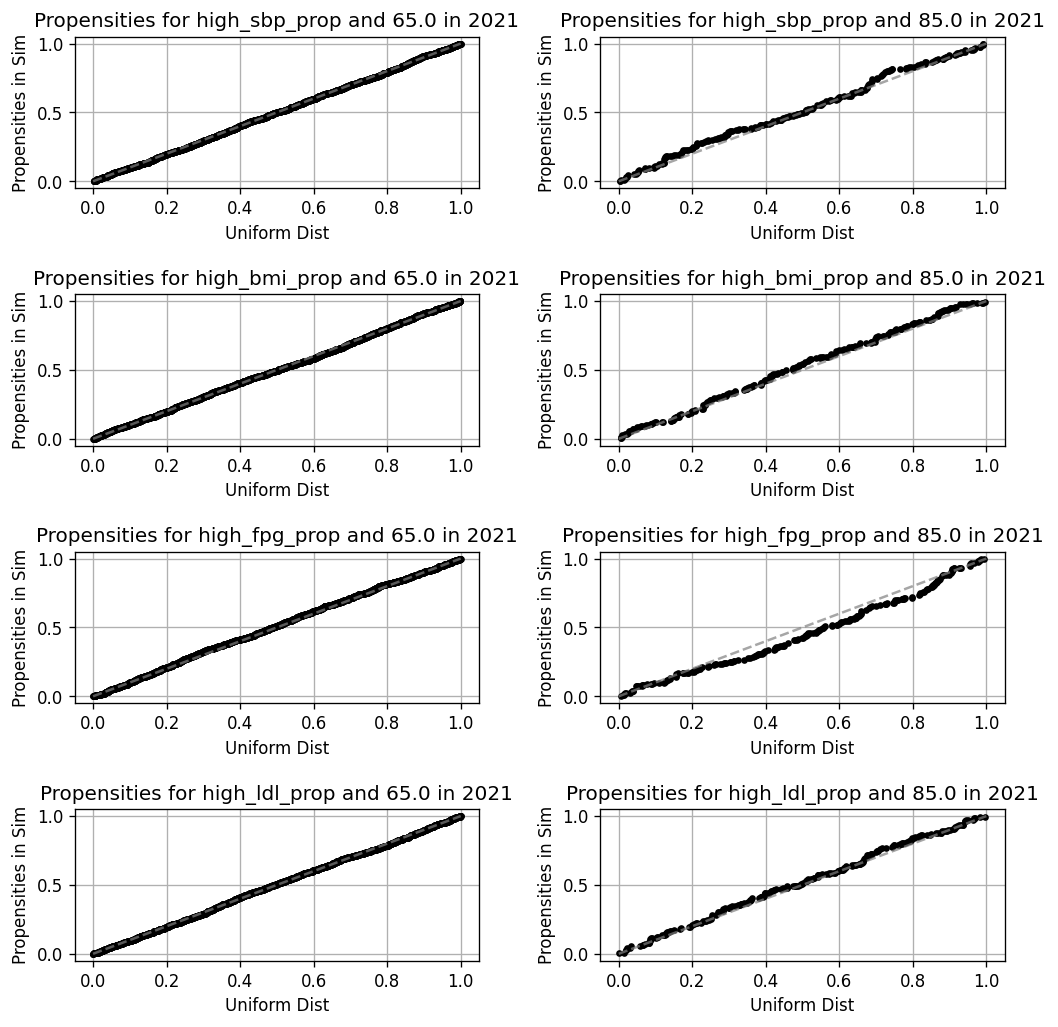

In [15]:
fig, ax = plt.subplots(len(risks), data1_small.age_start.nunique(), dpi=120, figsize=(10,10))
plt.subplots_adjust(wspace=.3, hspace=.7)
for i, risk in enumerate(risks):
    for j, age in enumerate(data1_small.age_start.unique()):
        d = data1_small.query('age_start == @age')
        
        ax[i][j].plot(np.sort(np.random.uniform(size=len(d))),
         d[risk].sort_values(), 'k.')
        ax[i][j].plot([0,1], [0,1], '--', color='grey', alpha=.7)
        ax[i][j].grid()
        ax[i][j].set_xlabel('Uniform Dist')
        ax[i][j].set_ylabel('Propensities in Sim');
        ax[i][j].set_title(f'Propensities for {risk} and {age} in 2021')
        

In [16]:
%%time

sim_data = pd.DataFrame()
for step in list(range(0,12*6)):
    print(step, end=', ', flush=True)
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('high_ldl_prop'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('high_sbp_prop'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('high_bmi_prop'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('high_fpg_prop')],
                       axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, CPU times: user 2h 29min 2s, sys: 36.1 s, total: 2h 29min 38s
Wall time: 2h 29min 14s


In [17]:
test_data = sim_data
test_data = test_data.loc[(test_data.age > 25) & (test_data.alive == 'alive')]
test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
test_data_small = test_data.loc[(test_data.step==24) & (test_data.sex=='Male')]
test_data_small = test_data_small.loc[(test_data_small.age_start == 85) | (test_data_small.age_start == 65)]
test_data_small

,tracked,age,entrance_time,alive,sex,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl,high_sbp,high_bmi,high_fpg,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,step,age_start
17,True,87.791266,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.000000,...,3.790547,123.691047,26.792920,5.393055,0.905945,0.190968,0.538555,0.436118,24,85.0
79,True,68.227310,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.000000,...,3.107551,152.776582,24.150578,4.460897,0.472558,0.895048,0.180425,0.179076,24,65.0
103,True,69.566340,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.000000,...,1.827298,172.446541,28.757589,6.838239,0.109932,0.975411,0.367850,0.697669,24,65.0
159,True,65.537672,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.000000,...,5.500000,157.068528,31.478000,5.525473,0.986903,0.931437,0.689634,0.491468,24,65.0
214,True,68.324640,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.000000,...,2.899898,120.616701,28.432067,6.942273,0.531194,0.288044,0.459662,0.758341,24,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49892,True,66.088834,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.000000,...,3.979945,154.974783,41.843894,5.126627,0.870365,0.921543,0.964961,0.360340,24,65.0
49894,True,69.111801,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.000000,...,2.532310,136.665378,20.297680,4.818877,0.353080,0.787458,0.032725,0.244054,24,65.0
49910,True,67.899017,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.000000,...,1.811824,105.268385,28.355821,4.835615,0.050897,0.057141,0.453884,0.291568,24,65.0
49948,True,87.348891,2020-12-04,alive,Male,NaT,Washington,not_dead,0.0,0.062788,...,2.074448,128.693971,31.774550,4.731642,0.246339,0.369040,0.862387,0.221484,24,85.0


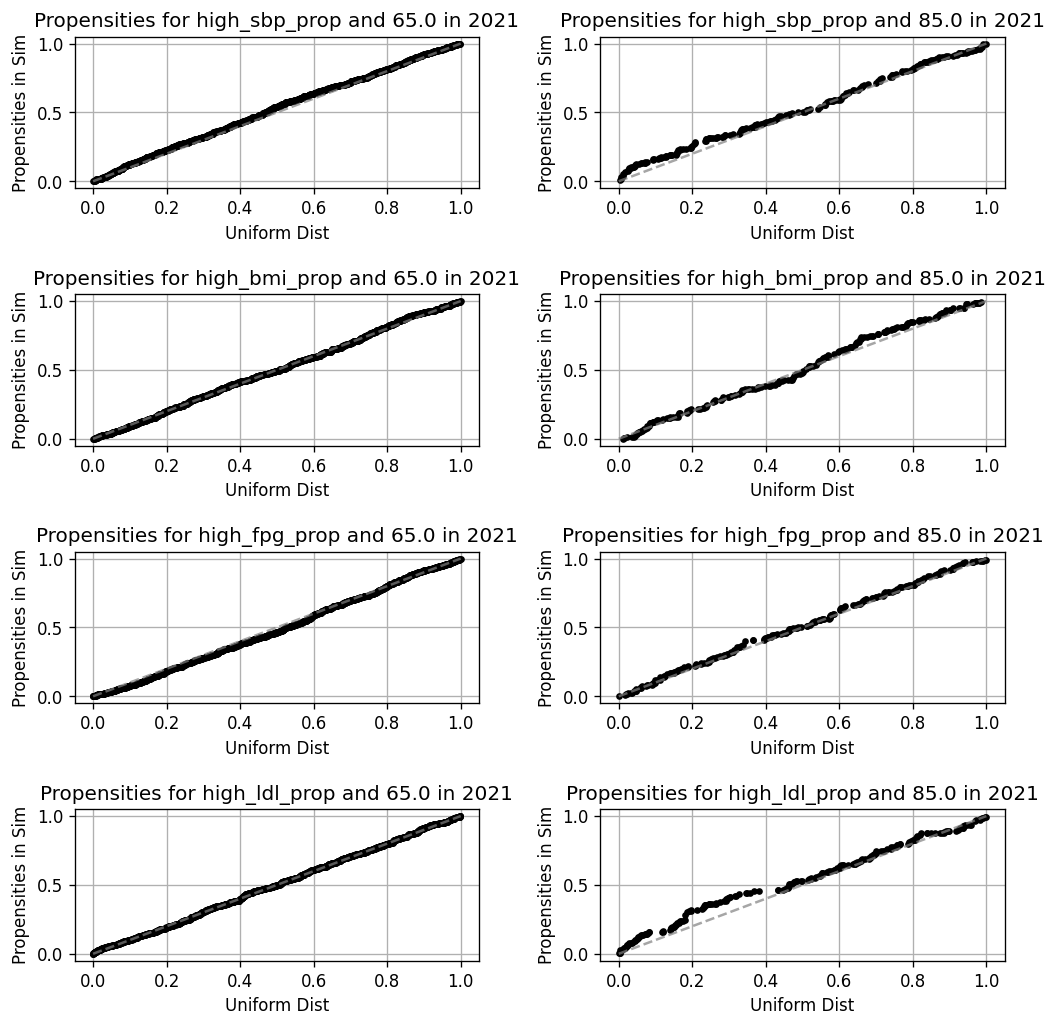

In [18]:
fig, ax = plt.subplots(len(risks), data1_small.age_start.nunique(), dpi=120, figsize=(10,10))
plt.subplots_adjust(wspace=.3, hspace=.7)
for i, risk in enumerate(risks):
    for j, age in enumerate(data1_small.age_start.unique()):
        d = test_data_small.query('age_start == @age')
        
        ax[i][j].plot(np.sort(np.random.uniform(size=len(d))),
         d[risk].sort_values(), 'k.')
        ax[i][j].plot([0,1], [0,1], '--', color='grey', alpha=.7)
        ax[i][j].grid()
        ax[i][j].set_xlabel('Uniform Dist')
        ax[i][j].set_ylabel('Propensities in Sim');
        ax[i][j].set_title(f'Propensities for {risk} and {age} in 2021')
        

In [19]:
# for risk in risks:
#     for age in test_data_small.age_start.unique():
#         ##Need to add a subdata statement here 
#         plt.figure()
#         plt.plot(np.sort(np.random.uniform(size=len(test_data_small))),
#          test_data_small[risk].sort_values(), 'k.')
#         plt.plot([0,1], [0,1], '--', color='grey', alpha=.7)
#         plt.grid()
#         plt.xlabel('Uniform Dist')
#         plt.ylabel('Propensities in Sim');
#         plt.title(f'Propensities for {risk} and {age} for 2023')

In [20]:
test_data_small.high_sbp.mean()

132.60022127415158

## Abie Testing

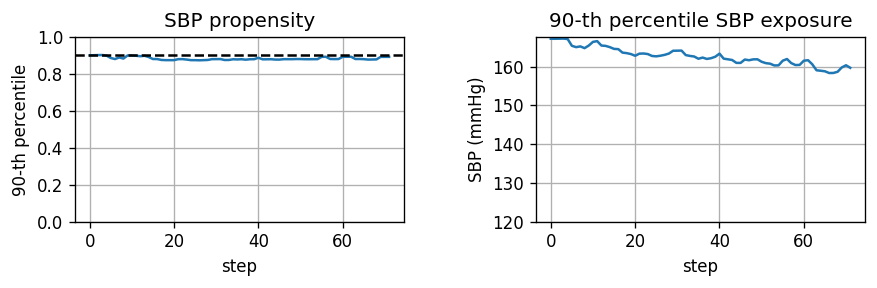

In [21]:
q = 90
age = 80
sex = "Male"
t = sim_data.query('alive == "alive" and sex == @sex and age >= @age and age < @age+5')

plt.figure(figsize=(8.5,2), dpi=120)
plt.subplot(1,2,1)
t.groupby('step').high_sbp_prop.apply(np.percentile, q=q).plot()
plt.axhline(q/100, color='k', linestyle='--')
plt.axis(ymin=0, ymax=1)
plt.ylabel(f'{q}-th percentile')
plt.title('SBP propensity')
plt.grid()

plt.subplot(1,2,2)
t.groupby('step').high_sbp.apply(np.percentile, q=q).plot()
# plt.axhline(120, color='k', linestyle='--')
plt.axis(ymin=120)
plt.ylabel(f'SBP (mmHg)')
plt.title(f'{q}-th percentile SBP exposure')
plt.grid()

plt.subplots_adjust(wspace=.4);

In [22]:
# how did I do? expect to see a bit of a drop, but maybe not so much

In [23]:
t.columns

Index(['tracked', 'age', 'entrance_time', 'alive', 'sex', 'exit_time',
       'location', 'cause_of_death', 'years_of_life_lost',
       'years_lived_with_disability',
       'previous_ischemic_heart_disease_and_heart_failure',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'susceptible_to_ischemic_stroke_event_count',
       's

In [24]:
t.filter(like='medication')

,sbp_medication_adherence_propensity,ldlc_medication_adherence_propensity,sbp_medication,ldlc_medication_adherence,sbp_medication_adherence,ldlc_medication
235,0.746436,0.373451,no_treatment,cat3,cat3,medium_intensity
354,0.735701,0.272135,one_drug_half_dose_efficacy,cat2,cat3,low_intensity
561,0.496684,0.118888,one_drug_half_dose_efficacy,cat1,cat3,no_treatment
653,0.383694,0.045650,no_treatment,cat1,cat3,low_intensity
848,0.192005,0.088542,one_drug_half_dose_efficacy,cat1,cat2,no_treatment
...,...,...,...,...,...,...
49606,0.349136,0.355573,one_drug_half_dose_efficacy,cat3,cat3,high_with_eze
49623,0.554986,0.294853,two_drug_half_dose_efficacy,cat2,cat3,low_intensity
49743,0.817740,0.204280,no_treatment,cat1,cat3,no_treatment
49929,0.799336,0.672080,no_treatment,cat3,cat3,medium_intensity


In [25]:
# here is a way to see if I got the overall amount of medication to line up
# but it will not show if the treatment types are also on target

sim_data['any_sbp_meds'] = (sim_data.sbp_medication != 'no_treatment')

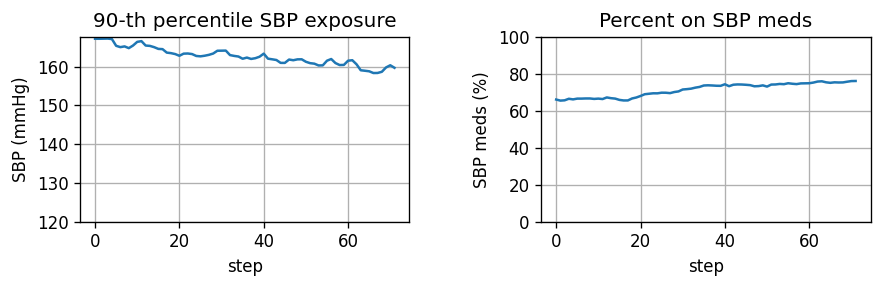

In [26]:
q = 90
age = 80
sex = "Male"
t = sim_data.query('alive == "alive" and sex == @sex and age >= @age and age < @age+5')

plt.figure(figsize=(8.5,2), dpi=120)
plt.subplot(1,2,1)
t.groupby('step').high_sbp.apply(np.percentile, q=q).plot()
# plt.axhline(120, color='k', linestyle='--')
plt.axis(ymin=120)
plt.ylabel(f'SBP (mmHg)')
plt.title(f'{q}-th percentile SBP exposure')
plt.grid()

plt.subplot(1,2,2)
(100*t.groupby('step').any_sbp_meds.apply(np.mean)).plot()
# plt.axhline(120, color='k', linestyle='--')
plt.axis(ymin=0, ymax=100)
plt.ylabel(f'SBP meds (%)')
plt.title(f'Percent on SBP meds')
plt.grid()

plt.subplots_adjust(wspace=.4);

# Compare to the results with no medication:
